In [151]:
import numpy as np 
import scipy.sparse as sps
import scipy.spatial
import scipy.linalg.lapack as lapack
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt



*N* - number of trajectory snapshots

*D* - dimension of a snapshot, in this case D = (4 atoms x 3 coordinates(x,y,z)) = 12

*data*: 
## Loading in  Data

**data** is an $N \times D$ array,  with $N = 100,000$ rows of data, $D = 12$ dimensions, of form
$$\text{data} = \left[
\begin{array}{ccc}
x_{0}^{(1)}  y_0^{(1)} z_0^{(1)} & x_0^{(2)} y_0^{(2)}  z_0^{(2)} & x_0^{(3)} y_0^{(3)}  z_0^{(3)} &  x_0^{(4)} y_0^{(4)}  z_0^{(4)} \\
\vdots & \vdots & \vdots & \vdots \\
x_{i}^{(1)}  y_i^{(1)} z_i^{(1)} & x_i^{(2)} y_i^{(2)}  z_i^{(2)} & x_i^{(3)} y_i^{(3)}  z_i^{(3)} &  x_i^{(4)} y_i^{(4)}  z_i^{(4)} \\  
\vdots & \vdots & \vdots & \vdots \\
x_{N-1}^{(1)}  y_{N-1}^{(1)} z_{N-1}^{(1)} & x_{N-1}^{(2)} y_{N-1}^{(2)}  z_{N-1}^{(2)} & x_{N-1}^{(3)} y_{N-1}^{(3)}  z_{N-1}^{(3)} &  x_{N-1}^{(4)} y_{N-1}^{(4)}  z_{N-1}^{(4)},   
\end{array}\right]$$

so that $[x_{i}^{(k)}  y_i^{(k)}  z_i^{(k)}] \in \mathbb{R}^3$ corresponds to the position of atom $k,$ for $k=1,2,3,4,$ at snapshot $i$.

------------------------------------------------------------------------------------------------------------------------------------------------

**dihedrals** is an $N \times 1$ array with $N = 100,000$ data points, with entry $i$ corresponding to the dihedral angle $\varphi(X_i)\in [-\pi, \pi]$ of snapshot $X_i = [x_{i}^{(1)}  y_i^{(1)} z_i^{(1)}  x_i^{(2)} y_i^{(2)}  z_i^{(2)}  x_i^{(3)} y_i^{(3)}  z_i^{(3)}   x_i^{(4)} y_i^{(4)}  z_i^{(4)}]^{\top}$

$$\text{dihedrals} = [\varphi(X_0) \ \varphi(X_1) \cdots \varphi(X_{N-1})]^{\top}$$

------------------------------------------------------------------------------------------------------------------------------------------------


**potentials** is an $N \times 1$ array with $N = 100,000$ data points, with entry $i$ corresponding to the potential energy of snapshot $X_i$
$$\text{potentials} = [V(X_0) \ V(X_1) \cdots V(X_{N-1})]^{\top}$$



------------------------------------------------------------------------------------------------------------------------------------------------

The original molecular dynamics simulation was done in OpenMM, simulation set up with:

temperature $T = 300$ Kelvin (K) [this is usually used as `room temperature']

timestep $\Delta t = 2$ femtoseconds (fs)  [1 fs = 1 x 10^-15 seconds]


simulation length T = **(1 x 10^7 steps) x (2 fs)** = 2 x 10^7 fs = 2 x 10^4 picoseconds (ps)
= **20 nanoseconds (ns)**

 [1 ps = 1000 fs = 1 x 10^-12 seconds ]

 [1 ns = 1000 ps = 1 x 10^-9 seconds ]

------------------------------------------------------------------------------------------------------------------------------------------------
**data**, **dihedrals**, **potentials** are subsampled every 100 steps from the original simulation, for $N =10^5$ data points at timestep $0.2$ ps


In [152]:
fname = "systems/butane/data/butane_hightemp.npz"
inData = np.load(fname)
print("Keys in data:")
print(list(inData.keys()))

data = inData["data"]
print("Data shape from trajectory:")
print(data.shape)
dihedrals = inData["dihedrals"]
potential = inData["potential"]
kbT = inData["kbT"]
kbT_roomtemp = inData["kbT_roomtemp"]

Keys in data:
['data', 'dihedrals', 'potential', 'kbT', 'kbT_roomtemp']
Data shape from trajectory:
(100000, 12)


### Dihedral: Probability Distribution and time-series plot

Text(0, 0.5, 'Dihedral Angle')

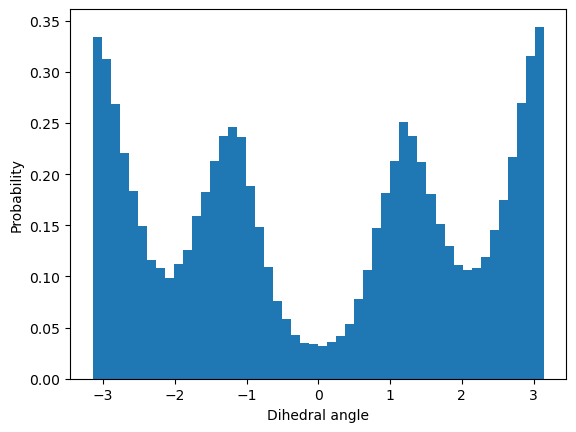

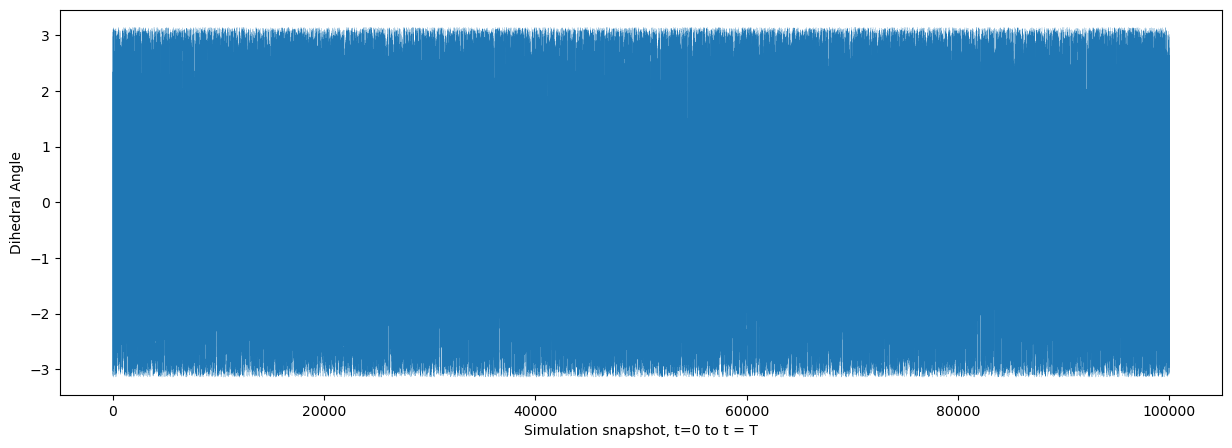

In [153]:
counts, bins, _ = plt.hist(dihedrals, bins=50, density=True)
plt.xlabel("Dihedral angle")
plt.ylabel("Probability")

plt.figure(figsize=(15,5))
plt.plot(dihedrals, linewidth=0.1)
plt.xlabel("Simulation snapshot, t=0 to t = T")
plt.ylabel("Dihedral Angle")


### Re-visualizing by shifting $[-\pi, 0]$ to $[\pi, 2\pi]$

Text(0, 0.5, 'Shifted Dihedral Angle')

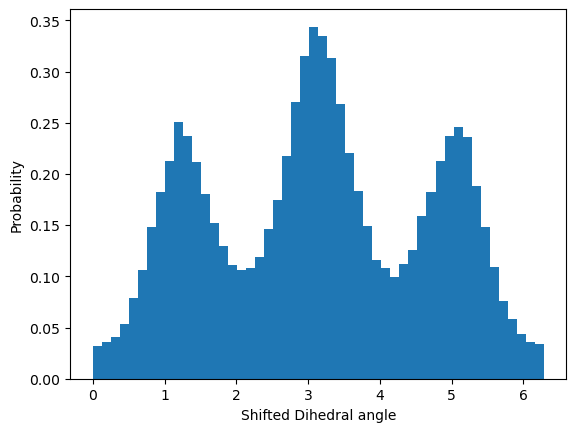

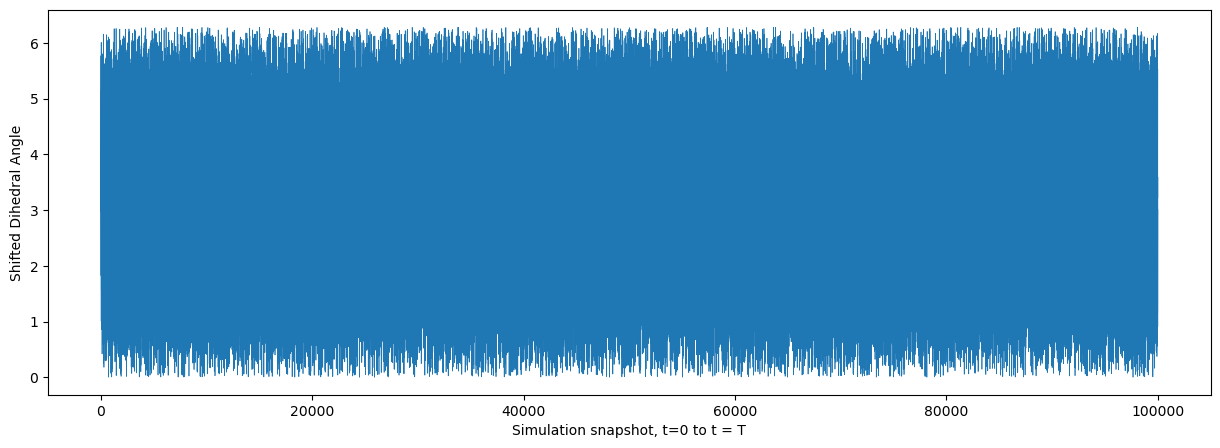

In [154]:
dihedrals_shift = dihedrals.copy()
dihedrals_shift[dihedrals < 0] = dihedrals_shift[dihedrals < 0] + 2*np.pi 
plt.figure()
counts, bins, _ = plt.hist(dihedrals_shift, bins=50, density=True)
plt.xlabel("Shifted Dihedral angle")
plt.ylabel("Probability")


plt.figure(figsize=(15,5))
plt.plot(dihedrals_shift, linewidth=0.5)
plt.xlabel("Simulation snapshot, t=0 to t = T")
plt.ylabel("Shifted Dihedral Angle")

In [155]:
gibbs = np.exp(-potential/(kbT))
#target_measure = np.exp(-potential/(kbT_roomtemp))
#target_measure = np.exp(-potential/(kbT_roomtemp))


In [156]:
# Create subsampled data set
sub = 10
new_data = data[::sub, :]
#target_measure = np.exp(-potential[::sub]/(kbT))
target_measure = np.exp(-potential[::sub]/(kbT_roomtemp))
num_features = new_data.shape[1]
num_samples = new_data.shape[0]


In [169]:
epsilon = 0.05
eps_radius = 3*np.sqrt(epsilon)

In [170]:
### Create distance matrix
#neigh = NearestNeighbors(radius = eps_radius)
neigh = NearestNeighbors(n_neighbors=256)
neigh.fit(new_data)
#sqdists = neigh.radius_neighbors_graph(new_data, mode="distance") 
sqdists = neigh.kneighbors_graph(new_data, mode="distance")
print(f"Data type of squared distance matrix: {type(sqdists)}")

### Create Kernel
K = sqdists.copy()
K.data = np.exp(-K.data / (2*epsilon))
print(f"Data type of kernel: {type(K)}")

# Check sparsity of kernel
num_entries = K.shape[0]**2
nonzeros_ratio = K.nnz / (num_entries)
print(f"Ratio of nonzeros to zeros in kernel matrix: {nonzeros_ratio}")




Data type of squared distance matrix: <class 'scipy.sparse._csr.csr_matrix'>
Data type of kernel: <class 'scipy.sparse._csr.csr_matrix'>
Ratio of nonzeros to zeros in kernel matrix: 0.0256


In [171]:
### Create Graph Laplacian
kde = np.asarray(K.sum(axis=1)).squeeze()
kde *=  (1.0/num_samples)*(2*np.pi*epsilon)**(-num_features/2) 
u = (target_measure**(0.5)) / kde
U = sps.spdiags(u, 0, num_samples, num_samples) 
W = U @ K @ U
stationary = np.asarray(W.sum(axis=1)).squeeze()
P = sps.spdiags(1.0/stationary, 0, num_samples, num_samples) @ W 
L = (P - sps.eye(num_samples, num_samples))/epsilon

# Define A,B sets

In [172]:
radius = 0.2
Acenter = -np.pi/3
Bcenter = np.pi/3
#A = np.abs(dihedrals[::sub] - Acenter) < radius
#B = np.logical_or(np.abs(dihedrals[::sub] - np.pi) < radius, np.abs(dihedrals[::sub] + np.pi) < radius)

#A = np.abs(dihedrals[::sub] - Acenter) < radius
#B = np.logical_or(np.abs(dihedrals[::sub] - np.pi) < radius, np.abs(dihedrals[::sub] + np.pi) < radius)

A = np.abs(dihedrals[::sub] - Acenter) < radius
B = np.abs(dihedrals[::sub] - Bcenter) < radius

C = np.ones(num_samples, dtype=bool)
C[A] = False
C[B] = False

# Find isolated points
isolated = np.asarray(sqdists.sum(axis=1)).squeeze() == 0
print(isolated[isolated > 0])
nonisolated = ~isolated

A_nonisolated = np.logical_and(A, nonisolated) 
B_nonisolated = np.logical_and(B, nonisolated)
C_nonisolated = np.logical_and(C, nonisolated)



[]


In [173]:
### Solve Committor
Lcb = L[C_nonisolated, :]
Lcb = Lcb[:, B_nonisolated]
Lcc = L[C_nonisolated, :]
Lcc = Lcc[:, C_nonisolated]
q = np.zeros(num_samples)
q[B] = 1
row_sum = np.asarray(Lcb.sum(axis=1)).squeeze()
q[C_nonisolated] = sps.linalg.spsolve(Lcc, -row_sum)
q[isolated] = np.nan

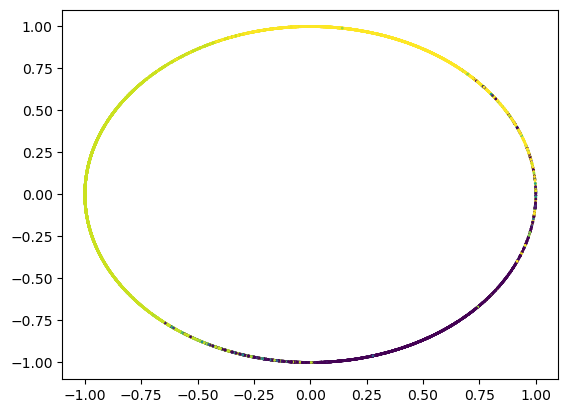

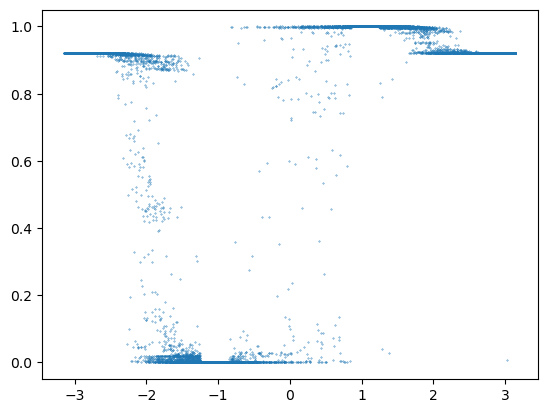

In [174]:
plt.figure()
plt.scatter(np.cos(dihedrals[::sub]),np.sin(dihedrals[::sub]), c=q, s=1)

plt.figure()
plt.scatter(dihedrals[::sub], q, s=0.1)